In [1]:
from operator import itemgetter

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.gaussian_process as gp
import useful_rdkit_utils as uru
from modAL.acquisition import BaseLearner
from modAL.models import BayesianOptimizer
from modAL.utils.data import modALinput
from rdkit import Chem
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm.auto import tqdm
from evaluators import FredEvaluator

As with the classification example, we'll define an oracle that looks up values from a dataframe.  

In [26]:
class Oracle:
    def __init__(self, df, col_name, invert=True):
        self.fred_eval = FredEvaluator({"design_unit_file": "data/2zdt_receptor.oedu"})
        self.df = df

    def sample(self, num):
        sample_df = self.df.sample(num)
        scores = [self.fred_eval.evaluate(x)*-1.0 for x in sample_df.mol]
        return sample_df.fp.values, scores, sample_df.index

    def get_values(self, idx_list):
        sample_df = df.iloc[idx_list]
        scores = [self.fred_eval.evaluate(x)*-1.0 for x in sample_df.mol]
        return scores

We're going to use Gaussian Process Regression (GPR) to build our regression models.  To use GPR, we need to define a kernel function.  In this case, we'll calculate a kernel based on the Tanimoto coefficient.

In [4]:
def calculate_similarity(a, b):
    # Tanimoto similarity a vs. b
    aa = np.sum(a, axis=1, keepdims=True)
    bb = np.sum(b, axis=1, keepdims=True)
    ab = np.matmul(a, b.T)
    return np.true_divide(ab, aa + bb.T - ab)


class TanimotoKernel(gp.kernels.NormalizedKernelMixin,
                     gp.kernels.StationaryKernelMixin, gp.kernels.Kernel):

    def __init__(self):
        pass

    def __call__(self, X, Y=None, eval_gradient=False):
        assert not eval_gradient
        if Y is None:
            Y = X
        return calculate_similarity(X, Y)

Enable progress bars for the Pandas apply function.

In [12]:
tqdm.pandas()

Read the input data.  This data comes from ["Optimizing active learning for free energy calculations"](https://www.sciencedirect.com/science/article/pii/S2667318522000204)

In [13]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/google-research/google-research/master/al_for_fep/tyk2_dataset/tyk2_fep.csv")

Rename the SMILES column, this is strictly a convenience issue.

In [14]:
df.rename(columns={"Smiles": "SMILES"}, inplace=True)

Take a quick look at the data.

In [15]:
df

,LigandId,DockingScore,SMILES,dG,dGError
0,0,-8.654,O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1c(Cl)cccc1Cl,-2.995,0.455
1,1,-8.126,O=C(Nc1ccnc(NC(=O)C2CCCC2)c1)c1ccccc1Cl,8.731,0.462
2,2,-8.655,O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1ccccc1Cl,3.316,0.448
3,3,-8.429,O=C(Nc1ccnc(NC(=O)C2CC2)c1)c1c(Cl)cc(Cl)cc1Cl,-0.070,0.462
4,4,-8.458,O=C(Nc1ccnc(NC(=O)C2CC2)c1)c1cc(Cl)ccc1Cl,3.431,0.449
...,...,...,...,...,...
9992,9994,-8.900,COc1cc(Cl)c(C(=O)Nc2cc(Nc3cccc(C(N)=O)n3)ncc2F...,3.288,0.512
9993,9995,-8.371,COc1ccnc(Nc2cc(NC(=O)c3cccc(Cl)c3N)c(F)cn2)c1,15.143,0.478
9994,9996,-8.897,O=C(COCc1ccccc1)Nc1cc(NC(=O)c2cccc(Cl)c2)c(F)cn1,5.480,0.500
9995,9997,-8.218,COc1c(F)cccc1C(=O)Nc1ccnc(NC(=O)NC(C)C)c1,10.696,0.467


Add an RDKit molecule column to the dataframe.

In [16]:
df['mol'] = df.SMILES.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/9997 [00:00<?, ?it/s]

Add a fingerprint column to the dataframe.

In [17]:
df['fp'] = df.mol.progress_apply(uru.mol2morgan_fp)

  0%|          | 0/9997 [00:00<?, ?it/s]

Create a pool for fingerprints for the active learning algorithm to draw from.

In [18]:
X_pool = np.stack(df.fp.values)

For the greedy search, we want to select the best scoring molecules, but we want to avoid selecting the same molecules multiple times. This function accepts a list of predictions and does the following.
- Sort by score
- Remove the molecules that were previously selected
- Return the top **n_to_choose**

In [19]:
def find_best_idx(predicted, used, num_to_choose):
    tmp_list = list(enumerate(predicted))
    tmp_list.sort(key=itemgetter(1), reverse=True)
    tmp_list = [x for x in tmp_list if x[0] not in used]
    tmp_list = [x[0] for x in tmp_list]
    return tmp_list[:num_to_choose]

The function performs the greedy search and selects the top **n** molecules that were not previously selected.

In [20]:
def greedy(optimizer: BaseLearner, X: modALinput, n_instances=1, used=[]):
    res = optimizer.predict(X)
    best_idx = find_best_idx(res, used, n_instances)
    return best_idx, X[best_idx]

Create an oracle that will return values.

In [28]:
value_column = "dG"
oracle = Oracle(df, value_column)

This is the main active learning loop.

In [32]:
n_instances = 100
n_cycles = 10

query_strategy = greedy
X_initial, y_initial, sample_idx = oracle.sample(n_instances)
optimizer = BayesianOptimizer(estimator=GaussianProcessRegressor(kernel=TanimotoKernel()),
                              X_training=np.stack(X_initial), y_training=y_initial,
                              query_strategy=query_strategy)

val_list = []
used = list(sample_idx)
for i in tqdm(range(0, n_cycles)):
    query_idx, query_desc = optimizer.query(X_pool, n_instances=n_instances, used=used)
    vals = oracle.get_values(query_idx)
    val_list.append(vals)
    optimizer.teach(query_desc, vals)
    used += query_idx

  0%|          | 0/10 [00:00<?, ?it/s]

Let's look at how the scores were distributed across the active learning cycles. First we need to put the data in a dataframe.

In [33]:
res_list = []
for idx, v in enumerate(val_list):
    res_list += [(idx, x) for x in v]
res_df = pd.DataFrame(res_list, columns=["idx", value_column])

Plot the data as boxplot.

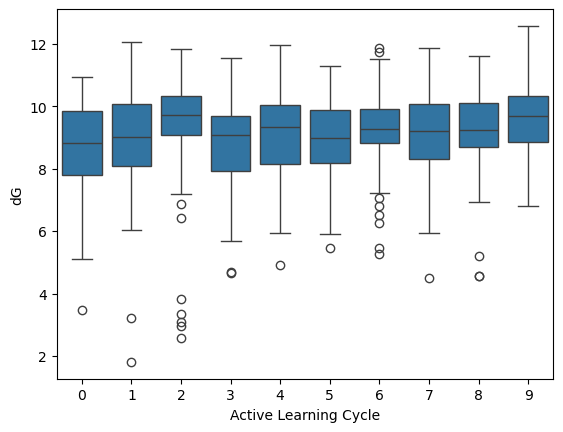

In [36]:
ax = sns.boxplot(x="idx", y=value_column, data=res_df.query("dG > 0"))
ax.set_xlabel("Active Learning Cycle");

In [43]:
rand_list = np.random.choice(len(df),1000, replace=False)

In [44]:
rand_scores = oracle.get_values(rand_list)

In [54]:
cmp_df = pd.DataFrame({"AL": sorted(res_df.dG.values,reverse=True)[:100], 
                       "RND": sorted(rand_scores,reverse=True)[:100]})
melt_df = cmp_df.melt()
melt_df.columns = ["method","score"]

<Axes: xlabel='method', ylabel='score'>

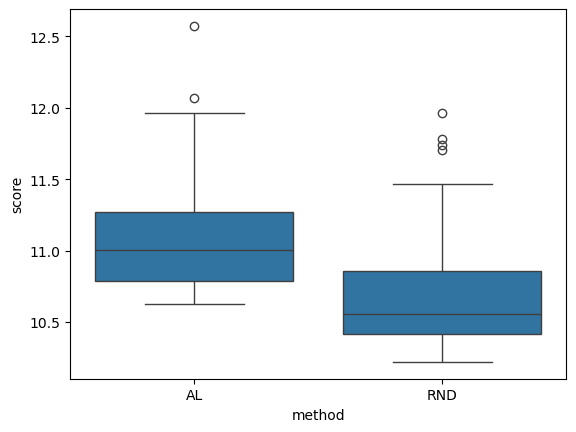

In [55]:
sns.boxplot(x="method",y="score",data=melt_df.query("score > 0"))

In [56]:
melt_df.method.value_counts()

method
AL     100
RND    100
Name: count, dtype: int64